# Introduction

Hello, I'm **Wesley**, nice to meet you ! 👋

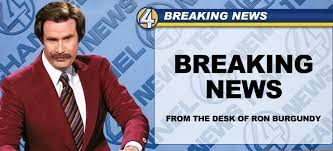

**BREAKING: We are making a news topic classifier!**

Here we'll using transfer learning on [BERT](https://huggingface.co/distilbert-base-uncased) with the [AG News Dataset](https://huggingface.co/datasets/ag_news).

To try out the model without running the notebook, check out my [HuggingFace](https://huggingface.co/wesleyacheng/news-topic-classification-with-bert).

# Setup Python Libraries

In [ ]:
%%bash
pip install numpy torch datasets transformers~=4.28.0 evaluate tqdm --quiet

In [2]:
%%bash
pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==2.1.0
evaluate==0.4.0
numpy==1.23.5
torch @ file:///tmp/torch/torch-2.0.0-cp310-cp310-linux_x86_64.whl#sha256=3a7abcaa5ae70fd4eb83c2cc43abc8ba94995316c6433e171d7454f107d41b58
torchaudio @ file:///tmp/torch/torchaudio-2.0.1-cp310-cp310-linux_x86_64.whl#sha256=83e258b68459f1ff64301c19c2fc791a692fd372271abeef8414854aafd03b06
torchdata==0.6.0
torchinfo==1.8.0
torchmetrics==0.11.4
torchtext @ file:///tmp/torch/torchtext-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=110ca71f44e505c040ea2f41dcaf798cd7de1b55cbedaa6687b9e21eec759844
torchvision @ file:///tmp/torch/torchvision-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=3b0e4e01ab713c145b7e20684eb79f983e75c8c13034901f21e3e8a36a1b3292
transformers==4.28.1


# Create News Topic Dataset

In [ ]:
from datasets import load_dataset

# let's get the news dataset from HuggingFace Hub
# https://huggingface.co/datasets/ag_news
raw_datasets = load_dataset('ag_news')

In [4]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [5]:
# let's set a seed for reproducibility
SEED = 42

In [6]:
# let's create a validation set (10%) for finding the model with best generalizability
train_validation_datasets = raw_datasets['train'].train_test_split(test_size=0.1, seed=SEED)
train_validation_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 108000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12000
    })
})

In [7]:
from datasets import DatasetDict

# create datasets for fine-tuning
datasets = DatasetDict({
    'train': train_validation_datasets['train'],
    'validation': train_validation_datasets['test'],
    'test': raw_datasets['test']
})
datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [8]:
# get class label information from dataset
num_labels = datasets['train'].features['label'].num_classes
id2label = {}
label2id = {}
for label_id,label in enumerate(datasets['train'].features['label'].names):
    id2label[label_id] = label
    label2id[label] = label_id
    
print(f"NUM_LABELS: {num_labels}")
print(f"ID2LABEL: {id2label}")
print(f"LABEL2ID: {label2id}")

NUM_LABELS: 4
ID2LABEL: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
LABEL2ID: {'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}


In [9]:
import random
random.seed(SEED)

# get random integers in the range of 0 to train_dataset_length
EXAMPLE_INDICES = [random.randrange(len(datasets['train'])) for _ in range(3)]
EXAMPLE_INDICES

[83810, 14592, 3278]

In [10]:
for i in EXAMPLE_INDICES:
    text = datasets['train']['text'][i]
    label_id = datasets['train']['label'][i]
    label = id2label[label_id]
    print(f" TEXT[{i}]: {text}")
    print(f"LABEL[{i}]: {label} ({label_id})")
    print()

 TEXT[83810]: Hopes fade for China mine victims Rescuers express mounting fears for 86 people still missing after a gas explosion in a China coal mine killed 62.
LABEL[83810]: World (0)

 TEXT[14592]: Notebook: Breeders #39; Cup gives title hope to several The landscape has changed since Smarty Jones #39; meteoric rise from obscurity to stardom last spring, when the colt from Pennsylvania appeared to be 
LABEL[14592]: Sports (1)

 TEXT[3278]: Max Table size in MySQL \\It turns out that MySQL  has a terrible upper limit on the max MyISAM table\size.  It appears that innodb doesn't have this problem.\\Jeremy talks about it over on his blog \\"When this happens, the first reaction I hear is "You never told me that MySQL\has a 4GB limit! What am I going to do?" Amusingly, I usually do describe the\limit when I discuss the possibility of using MySQL with various groups--they\often forget or underestimate the impact it will have. Putting that aside, the\problem is easily fixed, as that page 

In [ ]:
from transformers import AutoTokenizer

# get fast BERT tokenizer 
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

In [ ]:
# tokenize and truncate dataset by batch, while removing unused column
tokenized_datasets = datasets.map(lambda x: tokenizer(x['text'], truncation=True), batched=True, remove_columns=['text'])
# rename for multiclass fine-tuning
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
# set format to pytorch
tokenized_datasets.set_format(type='torch')

In [13]:
# there will be 3 columns
# labels: the true class label that corresponds to this news
# input_ids: the token ids based on the tokenizer
# attention_mask: the attention boolean map of token ids
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

In [14]:
for i in EXAMPLE_INDICES:
    text = datasets['train']['text'][i]
    tokenized_text = tokenized_datasets['train']['input_ids'][i]
    label_id = tokenized_datasets['train']['labels'][i].item()
    label = id2label[label_id]
    print(f"          TEXT[{i}]: {text}")
    print(f"TOKENIZED_TEXT[{i}]: {tokenized_text}")
    print(f"         LABEL[{i}]: {label_id} ({label})")
    print()

          TEXT[83810]: Hopes fade for China mine victims Rescuers express mounting fears for 86 people still missing after a gas explosion in a China coal mine killed 62.
TOKENIZED_TEXT[83810]: tensor([  101,  8069, 12985,  2005,  2859,  3067,  5694,  5343,  2869,  4671,
        15986, 10069,  2005,  6564,  2111,  2145,  4394,  2044,  1037,  3806,
         7738,  1999,  1037,  2859,  5317,  3067,  2730,  5786,  1012,   102])
         LABEL[83810]: 0 (World)

          TEXT[14592]: Notebook: Breeders #39; Cup gives title hope to several The landscape has changed since Smarty Jones #39; meteoric rise from obscurity to stardom last spring, when the colt from Pennsylvania appeared to be 
TOKENIZED_TEXT[14592]: tensor([  101, 14960,  1024, 20823,  1001,  4464,  1025,  2452,  3957,  2516,
         3246,  2000,  2195,  1996,  5957,  2038,  2904,  2144,  6047,  2100,
         3557,  1001,  4464,  1025, 23879,  2594,  4125,  2013, 27885, 28817,
        15780,  2000,  2732,  9527,  2197,  3500, 

# Setup Dataloaders

In [ ]:
import torch

# set pytorch to current seed
torch.manual_seed(SEED)

In [16]:
# get current device, best use a gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
from transformers import DataCollatorWithPadding

# we use a data collator for dynamic batch padding 
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
from torch.utils.data import DataLoader

# setup dataloaders
dataloaders = {
    'train': None,
    'validation': None,
    'test': None,
}
for dataset_type in ['train', 'validation', 'test']:
    dataloaders[dataset_type] = DataLoader(
        dataset = tokenized_datasets[dataset_type],
        batch_size = 64,
        shuffle = True,
        collate_fn = data_collator,
    )

# Setup Training Configurations

In [ ]:
from transformers import AutoModelForSequenceClassification

# get model form HuggingFace Hub
# https://huggingface.co/distilbert-base-uncased
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)

# move model to current device
model.to(device)

In [20]:
from transformers import AdamW, get_scheduler

# let's use a linear scheduler with AdamW
scheduler_name = 'linear'
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0, no_deprecation_warning=True)
num_training_epochs = 1
num_training_steps = num_training_epochs * len(dataloaders['train'])
num_warmup_steps = 0
lr_scheduler = get_scheduler(
    name = scheduler_name,
    optimizer = optimizer,
    num_training_steps = num_training_steps,
    num_warmup_steps = num_warmup_steps,
)

print(f"           SCHEDULER NAME: {scheduler_name}")
print(f"                OPTIMIZER: {optimizer.__class__}")
print(f"NUMBER OF TRAINING EPOCHS: {num_training_epochs}")
print(f" NUMBER OF TRAINING STEPS: {num_training_steps}")

           SCHEDULER NAME: linear
                OPTIMIZER: <class 'transformers.optimization.AdamW'>
NUMBER OF TRAINING EPOCHS: 1
 NUMBER OF TRAINING STEPS: 1688


In [ ]:
from tqdm.auto import tqdm
import evaluate

# let's load the metrics for training and evaluation
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

In [22]:
def train(model, dataloader):
    # set to train mode
    model.train()
    loss = 0
    for batch in tqdm(dataloader):
        # reset gradients
        optimizer.zero_grad()
        
        # get predictions
        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)
        labels = batch['labels']
        
        # gradient descent
        outputs.loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        # accumulate metrics
        loss += outputs.loss.item()
        accuracy_metric.add_batch(predictions=predictions, references=labels)
        f1_metric.add_batch(predictions=predictions, references=labels)
    
    # return metrics
    loss /= len(dataloader)
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute(average='macro')
    return {'loss':loss, **accuracy, **f1}

In [23]:
def evaluate(model, dataloader):
    # set to evaluation mode
    model.eval()
    loss = 0
    # disable gradient computation
    with torch.no_grad():
        for batch in tqdm(dataloader):
            # get predictions
            batch = {k:v.to(device) for k,v in batch.items()}
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            labels = batch['labels']

            # accumulate metrics
            loss += outputs.loss.item() 
            accuracy_metric.add_batch(predictions=predictions, references=labels)
            f1_metric.add_batch(predictions=predictions, references=labels)
    
    # return metrics
    loss /= len(dataloader)
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute(average='macro')
    return {'loss':loss, **accuracy, **f1}

# Fine-Tune Model with Custom Dataset

## Let's see how an UnFine-Tuned BERT performs

In [24]:
test_metrics = evaluate(model, dataloaders['test'])
print(f"TEST ACCURACY: {test_metrics['accuracy']:.5f}", end=" ; ")
print(f"F1 (MACRO): {test_metrics['f1']:.5f}")

  0%|          | 0/119 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TEST ACCURACY: 0.22579 ; F1 (MACRO): 0.09931


We got **22% Accuracy** and **9% F1 (Macro)**, which is quite bad.😕

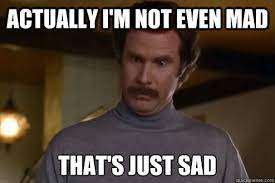

Let's do transfer learning on BERT! 🦾

## Fine-Tune BERT

In [25]:
for epoch in range(num_training_epochs):
    train_metrics = train(model, dataloaders['train'])
    validation_metrics = evaluate(model, dataloaders['validation'])
          
    print(f"EPOCH {epoch+1}", end=" | ")
    print(f"TRAIN LOSS: {train_metrics['loss']:.5f}", end=" | ")
    print(f"VALIDATION LOSS: {validation_metrics['loss']:.5f}", end=" ; ")
    print(f"ACCURACY: {validation_metrics['accuracy']:.5f}", end=" ; ")
    print(f"F1 (MACRO): {validation_metrics['f1']:.5f}")

  0%|          | 0/1688 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

EPOCH 1 | TRAIN LOSS: 0.22110 | VALIDATION LOSS: 0.16847 ; ACCURACY: 0.94083 ; F1 (MACRO): 0.94055


## Let's see how a Fine-Tuned BERT performs

In [26]:
test_metrics = evaluate(model, dataloaders['test'])
print(f"TEST ACCURACY: {test_metrics['accuracy']:.5f}", end=" ; ")
print(f"F1 (MACRO): {test_metrics['f1']:.5f}")

  0%|          | 0/119 [00:00<?, ?it/s]

TEST ACCURACY: 0.94066 ; F1 (MACRO): 0.94068


**WOAH!** We got **94% Accuracy** and **94% F1 (Macro)** in 1 epoch! 🤯

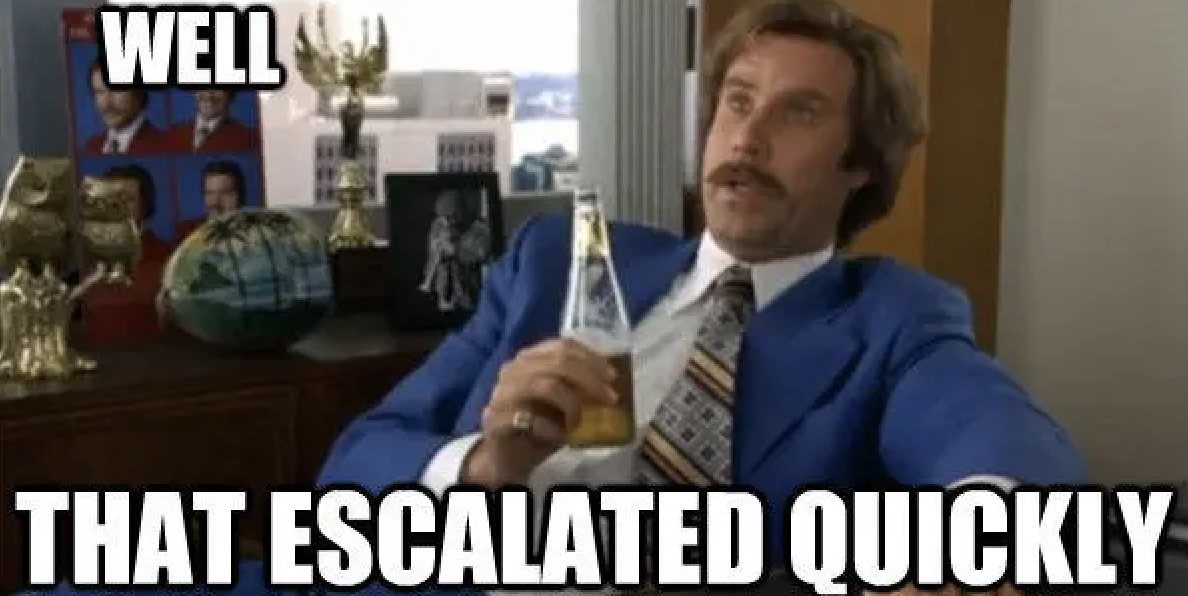

# Let's try out some examples!

In [27]:
from transformers import pipeline

news_topic_classifier = pipeline(task='text-classification', model=model, tokenizer=tokenizer, device=torch.cuda.current_device())

In [42]:
# I got a paragraph from a BBC article
# https://www.bbc.com/news/world-europe-65866880
world_news = """
Ukraine's President Volodymyr Zelensky appears to have confirmed that his country's long-awaited counter-offensive against Russia has started.
"Counter-offensive and defensive actions are taking place," he said.
"""

news_topic_classifier(world_news)

[{'label': 'World', 'score': 0.9968851208686829}]

In [41]:
# I got a paragraph from an ESPN article
# https://www.espn.com/nfl/draft2024/insider/story/_/id/37801703/2024-nfl-draft-quarterback-class-top-passers-know-big-questions
sports_news = """
The 2023 NFL draft class saw a record 12 quarterbacks selected in the first five rounds, including three inside the top five picks. The 2024 class? Expect some similarities.
"""

news_topic_classifier(sports_news)

[{'label': 'Sports', 'score': 0.9898658394813538}]

In [36]:
# I got a paragraph from a Wall Street Journal article
# https://www.wsj.com/articles/inflation-drags-eurozone-economy-into-recession-b6ff6158?mod=economy_more_pos1
business_news = """
Friday's jobs report does little to change the Federal Reserve's debate over holding rates steady this month.
But it strengthens the likelihood that officials would pair any June pause with a stronger preference to raise rates later this year.
"""

news_topic_classifier(business_news)

[{'label': 'Business', 'score': 0.9919977784156799}]

In [37]:
# I got a paragraph from a science.org article
# https://www.science.org/content/article/crops-grown-without-sunlight-could-help-feed-astronauts-bound-mars
science_news = """
According to one recent estimate, a crew of six would require an estimated 10,000 kilograms of food for the trip.
NASA—which plans to send people to Mars within 2 decades—could stuff a spacecraft with prepackaged meals and launch additional supplies to the Red Planet in advance for the voyage home.
But even that wouldn’t completely solve the problem.
"""

news_topic_classifier(science_news)

[{'label': 'Sci/Tech', 'score': 0.9886592626571655}]